# QuaNNTO Example — Cat-State Engineering via CV-QONNs (moment-matching)

This notebook demonstrates a **cat-state engineering** task with `QuaNNTO`.

## Goal
Train a CV-QONN to reproduce the **statistical moments** of a target single-mode quantum cat state.

In this example:
- The **dataset** contains precomputed cat-state moments (generated elsewhere in `quannto.dataset_gens.catstates_stats`).
- The CV-QONN is trained to **match the first `train_num_moments` moments**.
- We report the predicted moments and the **heralding / subtraction probability** (norms).

---
## Requirements
- Run from the QuaNNTO repo (or have it importable).
- You must have the dataset files:
  - `datasets/{dataset_name}_inputs.npy`
  - `datasets/{dataset_name}_outputs.npy`

If they are not available, generate them using `quannto.dataset_gens.catstates_stats`.

---


In [1]:
import sys
from pathlib import Path

# set repo_root to the parent directory to find 'quannto' modules
repo_root = Path.cwd().resolve().parent  
sys.path.insert(0, str(repo_root))

In [2]:
from functools import partial
import os
import numpy as np

from quannto.core.qnn_trainers import *
from quannto.utils.path_utils import datasets_dir, models_testing_results_path, models_train_losses_path
from quannto.utils.results_utils import *
from quannto.core.data_processors import *
from quannto.core.loss_functions import *

np.random.seed(42)


2026-02-19 20:42:54.456114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 20:42:54.456146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 20:42:54.456823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-19 20:42:54.961821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1) Hyperparameters

We configure a single CV-QONN (3 modes, 1 layer) with photon subtraction on selected modes.


In [3]:
# === HYPERPARAMETERS DEFINITION ===
qnns_modes = [3]
qnns_ladder_modes = [[[1, 2]]]
qnns_layers = [1]
qnns_is_addition = [False]

include_initial_squeezing = False
include_initial_mixing = False
is_passive_gaussian = False

n_inputs = 1
n_outputs = 1

# Special observable used by the trainer/model to output cat-state statistics
observable = 'catstates'

# Optional normalization range for inputs (None disables rescaling)
in_norm_ranges = [None] * len(qnns_modes)

# Optional initial parameter vectors per-QNN
qnn_params = [None] * len(qnns_modes)


## 2) Optimizer settings

We use a small number of basinhopping iterations for a lightweight example.
Increase `basinhopping_iters` for deeper optimization.


In [4]:
# === OPTIMIZER SETTINGS ===
optimize = build_and_train_model
loss_function = mse
basinhopping_iters = 2


## 3) Dataset settings (cat-state statistics)

The dataset is assumed to contain (for each input value) a vector of precomputed moments.

- `inputs.npy`: the input parameter(s) (here: a list of cat amplitudes `alpha_list`)
- `outputs.npy`: the target moments/statistics for the cat state

This notebook uses a single training sample (`dataset_size = 1`) to illustrate the workflow.


In [5]:
# === DATASET SETTINGS === (Statistics of a quantum cat state)
phi = 0.0
cutoff = 20
dataset_size = 1

input_range = (-1, 1)

num_moments = 15
train_num_moments = 15

alpha_list = np.linspace(input_range[0], input_range[1], dataset_size)

dataset_name = (
    f"catstate_phi{phi}_trainsize{dataset_size}_stats{num_moments}"
    f"_cut{cutoff}_rng{input_range[0]}to{input_range[-1]}"
)

task_name = (
    f"catstate_phi{phi}_trainsize{dataset_size}_stats{train_num_moments}"
    f"_cut{cutoff}_rng{input_range[0]}to{input_range[-1]}"
)

print("dataset_name:", dataset_name)
print("task_name:", task_name)


dataset_name: catstate_phi0.0_trainsize1_stats15_cut20_rng-1to1
task_name: catstate_phi0.0_trainsize1_stats15_cut20_rng-1to1


## 4) Load training dataset

This example expects the dataset to exist under `datasets/`.
If the dataset is missing, we raise a `FileNotFoundError` with instructions.


In [6]:
dataset_dir = str(datasets_dir() / dataset_name)

# Training dataset containing the statistical moments of the target cat state
if os.path.isfile(dataset_dir + "_inputs.npy") and os.path.isfile(dataset_dir + "_outputs.npy"):
    with open(dataset_dir + "_inputs.npy", "rb") as f:
        inputs = np.load(f)
    with open(dataset_dir + "_outputs.npy", "rb") as f:
        outputs = np.load(f)
else:
    raise FileNotFoundError(
        "The requested dataset does not exist. "
        "Generate it using quannto.dataset_gens.catstates_stats and place it under datasets/."
    )

# The trainer expects: [inputs, outputs]
# We keep only the first `train_num_moments` moments for training.
train_dataset = [np.array(inputs), np.array([outputs[0][:train_num_moments]])]

print("Train inputs:", train_dataset[0])
print("Target moments (truncated):", train_dataset[1])


Train inputs: [[-1.]]
Target moments (truncated): [[ 0.        +0.j  1.        +0.j  0.76159416+0.j  0.        +0.j
   0.        +0.j  1.76159416+0.j  1.        +0.j  3.76159416+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  4.52318831+0.j
   1.        +0.j  5.76159416+0.j 19.09275325+0.j]]


## 5) Build, train, and test the CV-QONN(s)

We train the model to match the chosen set of moments and evaluate it on the same training input.

Outputs:
- predicted moments from the QONN,
- subtraction probability (`norms`),
- training losses.


In [ ]:
qnns = []
train_losses = []
qnn_outs = []
legend_labels = []

for (N, l, ladder_modes, is_addition, in_norm_range, params) in zip(
    qnns_modes,
    qnns_layers,
    qnns_ladder_modes,
    qnns_is_addition,
    in_norm_ranges,
    qnn_params,
):
    # === NAME AND LEGEND OF THE QONN MODEL ===
    model_name = (
        task_name
        + "_N" + str(N)
        + "_L" + str(l)
        + ("_add" if is_addition else "_sub")
        + str(ladder_modes)
        + "_in" + str(in_norm_range)
    )

    nongauss_op = r"$\hat a^\dagger$" if is_addition else r"$\hat a$"
    legend_labels.append(
        f"N={N}, L={l}, {nongauss_op} in modes {np.array(ladder_modes[0]) + 1}"
    )

    # === PREPROCESSORS AND POSTPROCESSORS ===
    in_preprocessors = []
    if in_norm_range is not None:
        in_preprocessors.append(
            partial(rescale_data, data_range=input_range, scale_data_range=in_norm_range)
        )
    in_preprocessors.append(partial(pad_data, length=2 * N))

    out_preprocessors = []
    postprocessors = []

    # === BUILD, TRAIN AND TEST QNN ===
    qnn, train_loss, valid_loss = optimize(
        model_name,
        task_name,
        N,
        l,
        n_inputs,
        n_outputs,
        ladder_modes,
        is_addition,
        observable,
        include_initial_squeezing,
        include_initial_mixing,
        is_passive_gaussian,
        train_dataset,
        None,
        loss_function,
        basinhopping_iters,
        in_preprocessors,
        out_preprocessors,
        postprocessors,
        init_pars=params,
    )

    qnn_test_outputs, norms, loss_value = qnn.test_model(train_dataset[0], train_dataset[1], loss_function)

    print("\n=== Model:", model_name)
    print("Expected moments:", train_dataset[1])
    print("QONN output moments:", qnn_test_outputs)
    print("Subtractions probability (norms):", norms)

    qnns.append(qnn)
    train_losses.append(train_loss.copy())
    qnn_outs.append(qnn_test_outputs.copy())


 ========= QONN MODEL SPECIFICATIONS ========= 
Model name: catstate_phi0.0_trainsize1_stats15_cut20_rng-1to1_N3_L1_sub[[1, 2]]_inNone
Task name: catstate_phi0.0_trainsize1_stats15_cut20_rng-1to1
N=3, L=1, ladder modes=[[1, 2]], non-Gaussianity subtraction, observable=catstates
Initial squeezing: False, Initial mixing: False, Passive Gaussian: False
Input preprocessors: [functools.partial(<function pad_data at 0x7dd620f6b640>, length=6)]
Output preprocessors: []
Postprocessors: []
Number of parameters: 27
Number of terms for each trace: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Epoch  471 | Total epochs  471 | | Train loss 6.468178e-01
Basinhopping iteration 1. Loss: 0.6468177974860044
Epoch  428 | Total epochs  900 | | Train loss 6.236343e-02
Best loss so far: 0.6468177974860044
Basinhopping iteration 2. Loss: 0.062363434658363526
Epoch  418 | Total epochs 1319 | | Train loss 6.622978e-02
Best loss so far: 0.062363434658363526
Basinhopping iteration 3. Loss: 0.06622978099545325
Total training

2026-02-19 21:01:30.952883: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %gather.17 = s32[16,1,1,1,9496,20]{5,4,3,2,1,0} gather(%broadcast.233, %constant.173), offset_dims={1,2,3,4,5}, collapsed_slice_dims={}, start_index_map={0,1,2,3,4}, index_vector_dim=1, slice_sizes={1,1,1,9496,20}, indices_are_sorted=true, metadata={op_name="jit(predict_QNN)/jit(main)/gather" source_file="/home/tkrasimi/QuanticGit/Quannto/quannto/core/expectation_value.py" source_line=324}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2026-02-19 21:01:31.146345: E external/xla/xla/service/slow_operation_al


=== Model: catstate_phi0.0_trainsize1_stats15_cut20_rng-1to1_N3_L1_sub[[1, 2]]_inNone
Expected moments: [[ 0.        +0.j  1.        +0.j  0.76159416+0.j  0.        +0.j
   0.        +0.j  1.76159416+0.j  1.        +0.j  3.76159416+0.j
   0.        +0.j  0.        +0.j  0.        +0.j  4.52318831+0.j
   1.        +0.j  5.76159416+0.j 19.09275325+0.j]]
QONN output moments: [[ 1.55306792e-03-7.67306008e-03j  9.72697686e-01+2.51426123e-03j
   8.36982632e-01-1.80688343e-17j  7.72910682e-04-1.29283056e-03j
   1.71435513e-03-8.93112619e-03j  1.81209492e+00-4.00050684e-17j
   9.47443518e-01+1.51771163e-03j  3.72127018e+00+3.50317455e-03j
   3.69383649e-04+3.06484438e-03j  1.00824671e-03+4.79572459e-03j
  -1.42276060e-03-4.67243315e-03j  4.57966110e+00-1.52625353e-16j
   1.20431931e+00+2.32068078e-03j  5.70186592e+00+3.69548081e-03j
   1.90769929e+01-1.02786731e-03j]]
Subtractions probability (norms): [0.00125556+2.71050543e-20j]


## 6) Plot training losses

We plot the optimization trajectory for the trained model(s).


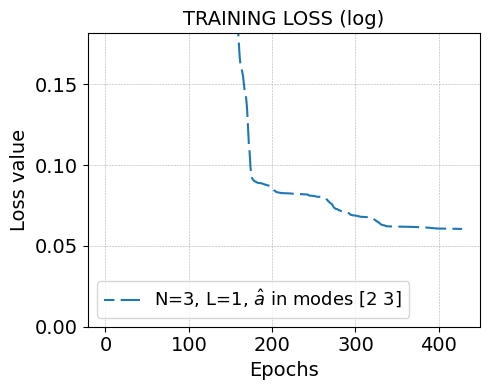

=== ACHIEVED TRAINING LOSSES ===
N=3, L=1, $\hat a$ in modes [2 3]: 0.062363434658363526


In [8]:
nongauss_ops = [r"$\hat a^\dagger$" if is_addition else r"$\hat a$" for is_addition in qnns_is_addition]
filename = (
    task_name
    + "_N" + str(qnns_modes)
    + "_L" + str(qnns_layers)
    + "_ph" + str(nongauss_ops)
    + str(qnns_ladder_modes)
)

plot_qnns_loglosses(train_losses, None, legend_labels, filename)


## 7) Plot expected vs. synthesized Wigner function of the cat state

Using Strawberry Fields, we can load the QONN model by specifying its hyperparameters, which would take each layer's symplectic matrix, displacement vector and subtractions. This will reconstruct the same quantum optical circuit of the model in Strawberry Fields, in an approximated way due to the cutoffs, and allow the Wigner function visualization and compute the fidelity of the synthesized cat state against the theoretical one.

N=3, L=1, â in modes [2, 3]
Conditional click probs per layer: [0.0012323220464878649]


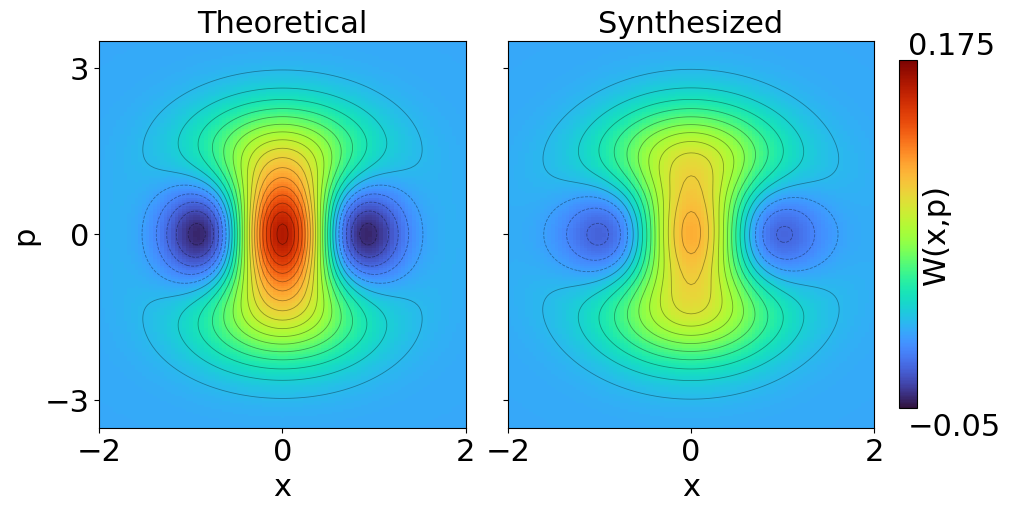

Fidelity on measured mode 0 (cat vs reduced QONN): 0.8235389729618662


In [9]:
import numpy as np

from quannto.utils.path_utils import figures_dir, models_operators_path
from quannto.utils.strawberryfields.general_tools import cat_even_ket, fidelity_pure_vs_mixed, fidelity_two_pure, mode_view_from_ket, reduced_rho_from_ket, six_order_moments_operators, mode_moments_from_ket
from quannto.utils.strawberryfields.wigner_plotters import *
from quannto.utils.strawberryfields.qonn_builder import run_qonn


N = 3
L = 1
subtractions = [[1,2]]
qnn_label = f'N={N}, L={L}, â in modes {[m+1 for m in subtractions[0]]}'
print(qnn_label)
cat_cutoff = 20
qonn_cutoff = 20
trained_stats = 15
input_alpha = -1.0 + 0.0j
phi = 0.0
qonn_model_name = f'catstate_phi{phi}_trainsize1_stats{trained_stats}_cut{cat_cutoff}_rng-1.0to-1.0_N{N}_L{L}_sub{subtractions}_inNone'

S_l = np.load(models_operators_path(qonn_model_name, "S_l", "npy"))
D_l = np.load(models_operators_path(qonn_model_name, "D_l", "npy"))

layers = []
for S,d in zip(S_l, D_l):
    layers.append({"S": S, "d": d})

title_cat = f"Wigner of cat state (alpha={input_alpha}, cutoff={cat_cutoff})"
title_qonn = f"Wigner of QONN ({qnn_label}) synthesized cat state (alpha={input_alpha}, cutoff={qonn_cutoff})"

ket_cat = cat_even_ket(input_alpha, cat_cutoff, phi=phi)
ket_out, probs = run_qonn(
    N=N, cutoff=qonn_cutoff,
    layers=layers,
    subtractions=subtractions,
    input_alpha=input_alpha   # Input encoding via displacement on mode 0, otherwise None
)
print("Conditional click probs per layer:", probs)

cat_stat_ops = six_order_moments_operators(cat_cutoff)
qonn_stat_ops = six_order_moments_operators(qonn_cutoff)
moments_cat = mode_moments_from_ket(ket_cat, cat_stat_ops, cutoff=cat_cutoff, mode=0)
moments_qonn = mode_moments_from_ket(ket_out, qonn_stat_ops, cutoff=qonn_cutoff, mode=0)

plot_wigner_2d_compare(
    ket_L=ket_cat,  N_L=1, cutoff_L=cat_cutoff, mode_L=0,
    ket_R=ket_out,   N_R=N, cutoff_R=qonn_cutoff, mode_R=0,
    grid_lim=4.0, grid_pts=201,
    zmin=-0.05, zmax=0.175,   # or leave None to auto-compute global min/max
    title_L="Theoretical", title_R="Synthesized",
    savepath=figures_dir() / "wigner_compare.pdf",
)

reduced_state_out = reduced_rho_from_ket(ket_out, cutoff=qonn_cutoff, N=N, mode=0)
if cat_cutoff == qonn_cutoff:
    if N==1:
        F0 = fidelity_two_pure(ket_cat, ket_out)
    else:
        F0 = fidelity_pure_vs_mixed(ket_cat, reduced_state_out)
    print("Fidelity on measured mode 0 (cat vs reduced QONN):", F0)

## Next steps

- Train on another `alpha` value generating a dataset for such cat state.
- Match higher-order moments by increasing `train_num_moments` (and possibly `cutoff`).
- Compare different architectures by sweeping `qnns_modes`, `qnns_layers`, and `qnns_ladder_modes`.
- Use photon addition by setting `qnns_is_addition = [True]`.
